Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.ticker as mtick
import seaborn as sns

sns.set()

Load Dataset

In [2]:
df = pd.read_csv('../ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df_dropped = df[(df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (df['gameType'] == 'R') & (
            df['periodType'] != 'SHOOTOUT')]

Preview the data

In [3]:
df_dropped.head(2)

,gameId,season,gameType,dateTime,team,eventIdx,event,isGoal,shotType,description,...,prevEvent,prevX,prevY,prevAngleWithGoal,secondsSincePrev,distanceFromPrev,rebound,changeOfAngleFromPrev,speed,speedOfChangeOfAngle
0,2015020001,20152016,R,2015-10-07T23:24:23Z,Toronto Maple Leafs,7,Shot,0.0,Wrist Shot,Brad Boyes Wrist Shot saved by Carey Price,...,Hit,94.0,-34.0,98.365886,11.0,154.275727,False,0.0,14.025066,0.0
1,2015020001,20152016,R,2015-10-07T23:24:38Z,Toronto Maple Leafs,9,Shot,0.0,Snap Shot,Nazem Kadri Snap Shot saved by Carey Price,...,Giveaway,-37.0,-28.0,12.528808,7.0,50.477718,False,0.0,7.211103,0.0


In [4]:
df_dropped.columns

Index(['gameId', 'season', 'gameType', 'dateTime', 'team', 'eventIdx', 'event',
       'isGoal', 'shotType', 'description', 'period', 'periodType',
       'periodTime', 'secondsSinceStart', 'strength', 'emptyNet', 'x', 'y',
       'rinkSide', 'distanceToGoal', 'angleWithGoal', 'shooter', 'goalie',
       'assist', 'scorer', 'prevSecondsSinceStart', 'prevEvent', 'prevX',
       'prevY', 'prevAngleWithGoal', 'secondsSincePrev', 'distanceFromPrev',
       'rebound', 'changeOfAngleFromPrev', 'speed', 'speedOfChangeOfAngle'],
      dtype='object')

In [5]:
df_filtered = df_dropped[['isGoal', 'distanceToGoal', 'angleWithGoal']]
df_filtered.head(1)

,isGoal,distanceToGoal,angleWithGoal
0,0.0,34.525353,10.00798


In [6]:
arg_non_goal = df_filtered[df_filtered["isGoal"] == 0].index
arg_to_delete = np.random.choice(arg_non_goal, size=len(df_filtered[df_filtered["isGoal"] == 0]) - len(df_filtered[df_filtered["isGoal"] == 1]), replace=False)

In [7]:
df_filtered = df_filtered.drop(labels=arg_to_delete, axis=0)

Split Train & Validation Dataset

In [8]:
train, test = train_test_split(df_filtered, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(37904, 3)
(18670, 3)


In [9]:
x = train['distanceToGoal'].to_numpy().reshape(-1, 1)

y = train['isGoal'].to_numpy()

x_test = test['distanceToGoal'].to_numpy().reshape(-1, 1)

y_test = test['isGoal'].to_numpy()

In [10]:
non_goal_ratio = len(y[y == 0])/len(y)
goal_ratio = 1 - non_goal_ratio
print(non_goal_ratio)
print(goal_ratio)

0.5004748839172647
0.4995251160827353


3.1 Create Logistic Regression Model

In [11]:
# instanciate a logistic regression model
clf = LogisticRegression()

# train model
clf.fit(x, y)

# score model
clf.score(x_test, y_test)

0.6558114622388859

3.2

Compute ROC and AUC

In [12]:
score_prob = clf.predict_proba(x_test)[:, 1]
y_test_pred = clf.predict(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)

0.6539970791904122


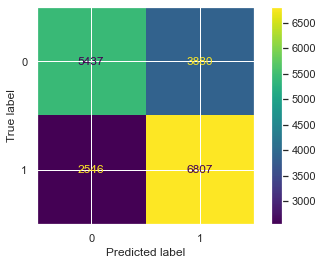

In [13]:
print(f1_score(y_test, y_test_pred, average='weighted'))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

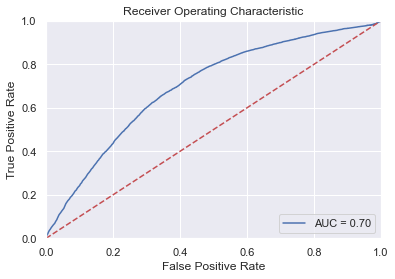

In [14]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Goal Rate

In [15]:
def prepare_goal_rate(y_array, score_prob):
    built_array = []
    index_array = list(range(0, 100, 5))
    total_goal = 0
    goal_array = []
    for i in range(0, 100, 5) :
        sub_y_array = y_array[np.logical_and(score_prob >= np.percentile(score_prob, i), score_prob < np.percentile(score_prob, i+5))]
        goals = np.count_nonzero(sub_y_array)
        shots = sub_y_array.size - goals
        sub_final = goals / (shots + goals)
        goal_array.append(goals)
        total_goal = total_goal + goals
        built_array.append(sub_final*100)
    return built_array, index_array, goal_array, total_goal

In [16]:
def create_goal_rate_plot(index_array, built_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, built_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['Baseline'])
    plt.title("Goal Rate")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Goals / (Shots + Goals)', fontsize=12)
    plt.show()

Cumulative % of Goals

In [17]:
def compute_cumulative(goal_array, total_goal):
    cumulative_array = []
    last_elem = 0
    for i in np.flip(goal_array):
        if total_goal != 0:
            current = i / total_goal*100 + last_elem
        else:
            current = last_elem
        cumulative_array.append(current)
        
        last_elem = current
    return cumulative_array

In [18]:
def create_cumulative_plot(index_array, cumulative_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, cumulative_array, color="blue")
    plt.xticks(np.arange(0, 110, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['Baseline'])
    plt.title("Cumulative % of goal")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.show()

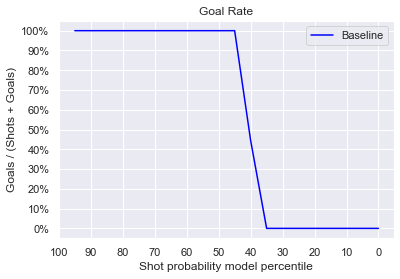

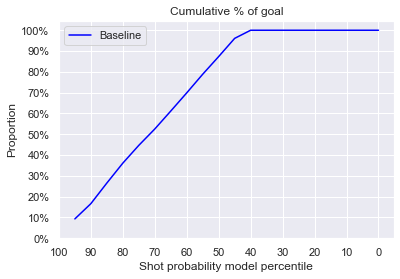

In [19]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_test_pred, score_prob)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

Calibration

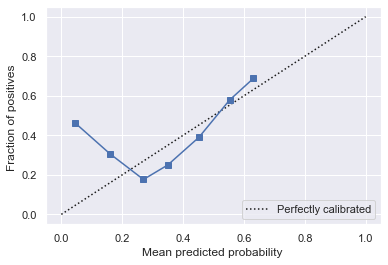

In [20]:
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

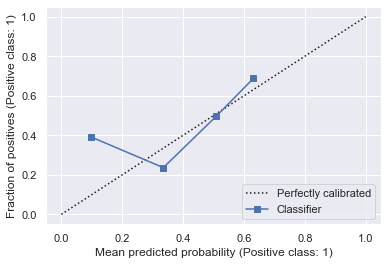

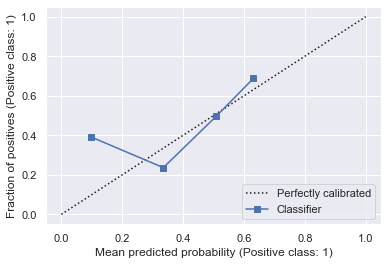

In [21]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob).plot()
plt.show()

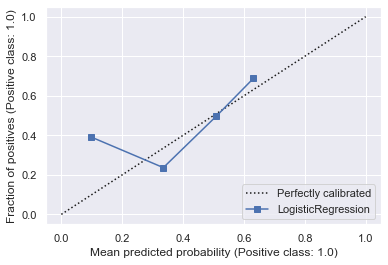

In [22]:
disp = CalibrationDisplay.from_estimator(clf, x_test, y_test)
plt.show()

Modèle 2 : angle 

In [23]:
x1 = train[['angleWithGoal']].to_numpy().reshape(-1, 1)

x1_test = test[['angleWithGoal']].to_numpy().reshape(-1, 1)

In [24]:
# instanciate a logistic regression model
clf = LogisticRegression()

# train model
clf.fit(x1, y)

# score model
clf.score(x1_test, y_test)

0.4951258703802892

In [25]:
score_prob1 = clf.predict_proba(x1_test)[:, 1]
y1_test_pred = clf.predict(x1_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob1)
roc_auc = metrics.auc(fpr, tpr)

0.4940628887330254


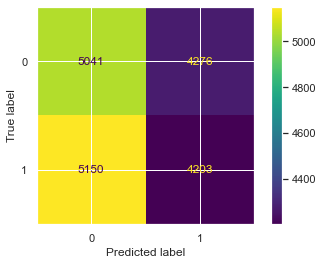

In [26]:
print(f1_score(y_test, y1_test_pred, average='weighted'))
ConfusionMatrixDisplay(confusion_matrix(y_test, y1_test_pred)).plot()
plt.show()

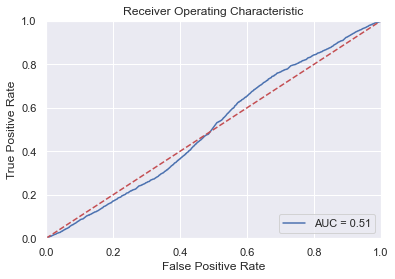

In [27]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

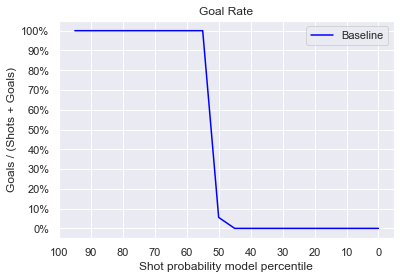

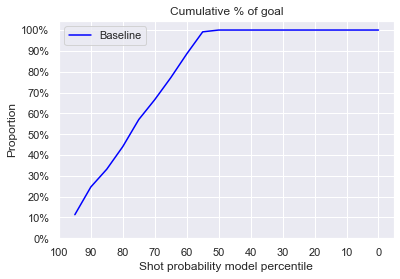

In [28]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y1_test_pred, score_prob1)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

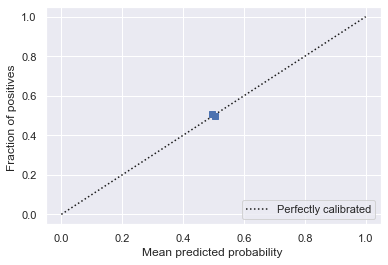

In [29]:
prob_true, prob_pred = calibration_curve(y_test, score_prob1, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob1).plot()
plt.show()

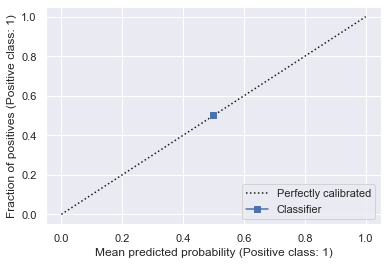

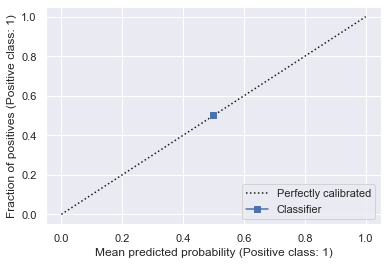

In [30]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob1).plot()
plt.show()

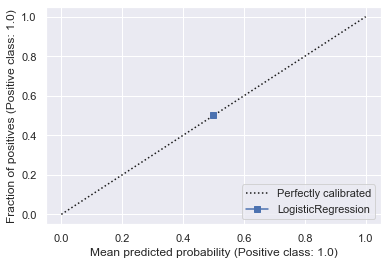

In [31]:
disp = CalibrationDisplay.from_estimator(clf, x1_test, y_test)
plt.show()

Modèle 3 : angle + distance

In [32]:
x2 = train[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

x2_test = test[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

In [33]:
# instanciate a logistic regression model
clf = LogisticRegression()

# train model
clf.fit(x2, y)

# score model
clf.score(x2_test, y_test)

0.6551687198714515

In [34]:
score_prob2 = clf.predict_proba(x2_test)[:, 1]
y2_test_pred = clf.predict(x2_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob2)
roc_auc = metrics.auc(fpr, tpr)

0.6533725140979866


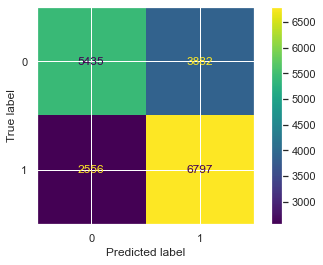

In [35]:
print(f1_score(y_test, y2_test_pred, average='weighted'))
ConfusionMatrixDisplay(confusion_matrix(y_test, y2_test_pred)).plot()
plt.show()

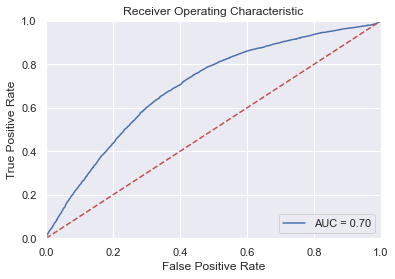

In [36]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

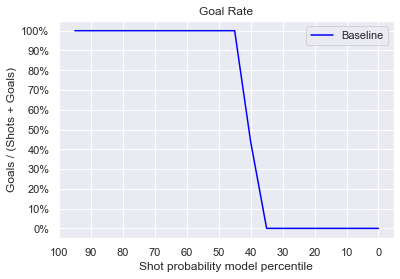

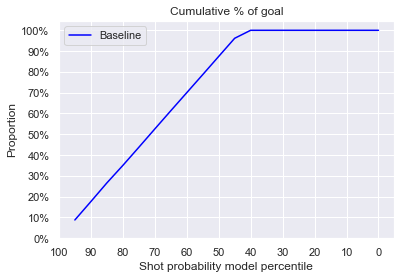

In [37]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y2_test_pred, score_prob2)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

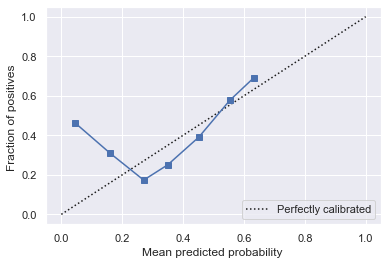

In [38]:
prob_true, prob_pred = calibration_curve(y_test, score_prob2, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob2).plot()
plt.show()

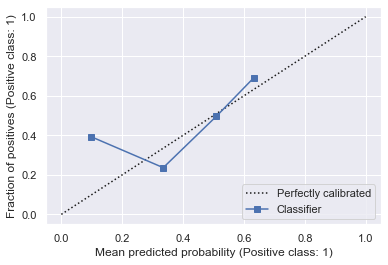

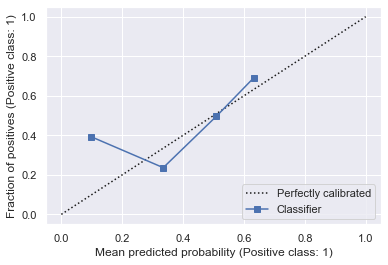

In [39]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob2).plot()
plt.show()

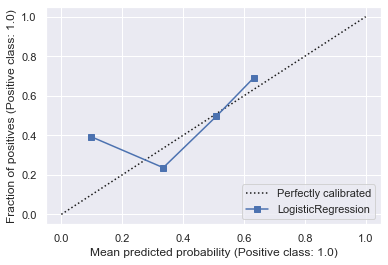

In [40]:
disp = CalibrationDisplay.from_estimator(clf, x2_test, y_test)
plt.show()

Modèle 4 : random

In [41]:
import random

score_prob3 = []
for i in range(len(test)):
    score_prob3.append(random.uniform(0, 1))
score_prob3 = np.array(score_prob3)
y3_test_pred = (score_prob3 >= 0.5).astype('int32')
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob3)
roc_auc = metrics.auc(fpr, tpr)

0.5012310986656829


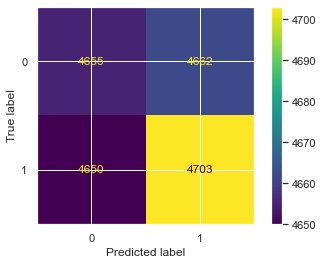

In [42]:
print(f1_score(y_test, y3_test_pred, average='weighted'))
ConfusionMatrixDisplay(confusion_matrix(y_test, y3_test_pred)).plot()
plt.show()

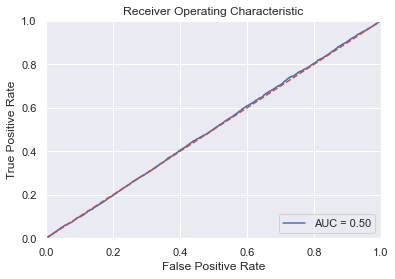

In [43]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

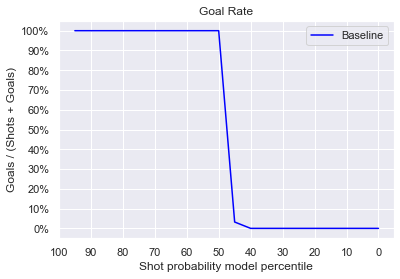

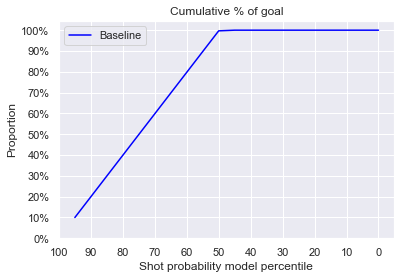

In [44]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y3_test_pred, score_prob3)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

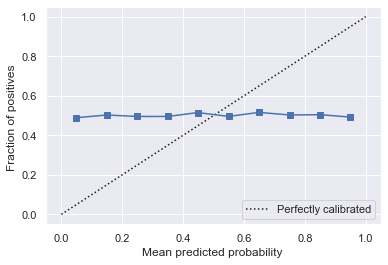

In [45]:
prob_true, prob_pred = calibration_curve(y_test, score_prob3, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob3).plot()
plt.show()

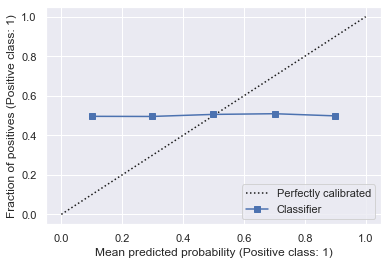

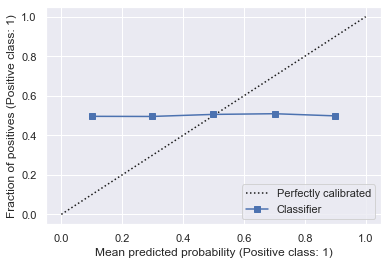

In [46]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob3).plot()
plt.show()

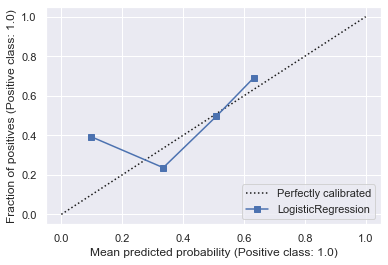

In [47]:
disp = CalibrationDisplay.from_estimator(clf, x2_test, y_test)
plt.show()